In [2]:
!pip install simpy

In [27]:
# Импортируем необходимые библиотеки
import simpy
import random
import numpy as np

# Задаем параметры производственных циклов (время в секундах)
CYCLE_TIME = {'A': 2.5 * 60, 'B': 1.5 * 60, 'C': 2 * 60}

# Вероятности задержек для каждого типа детали
DELAY_PROBABILITY = {'A': 0.02, 'B': 0.0175, 'C': 0.005}

# Параметры треугольного распределения задержек (в секундах) для каждого типа детали
DELAY_TRIANGLE = {
    'A': (5, 60, 15),
    'B': (5, 55, 20),
    'C': (5, 65, 20)
}

# Затраты за потерю деталей каждого типа
LOSS_COST = {'A': 15, 'B': 10, 'C': 12}

# Время загрузки и разгрузки поддонов (в секундах)
LOADING_UNLOADING_TIME = 25

# Емкость производственного буфера (в поддонах) и начальное количество поддонов
BUFFER_CAPACITY = 8
NUM_PALLETS = 40

# Вероятность задержки на входных линиях и параметры треугольного распределения для этих задержек
LINE_DELAY_PROBABILITY = 0.01
LINE_DELAY_TRIANGLE = (5, 15, 75)

# Таблицы с временами настройки (setup) для каждой детали и позиции
SETUP_TIMES = {
    'A': {'1': 25, '3': 52, '4': 35, '5': 29, '6': 11},
    'B': {'1': 20, '3': 21, '4': 22, '5': 14, '6': 19},
    'C': {'1': 17, '3': 34, '4': 24, '5': 37, '6': 17}
}

# Таблицы с временами выполнения операций для каждой детали (в секундах)
OPERATION_TIMES = {
    'A': {'1': 37, '3': 39, '4': 41, '5': 33, '6': 31},
    'B': {'1': 46, '3': 27, '4': 38, '5': 41, '6': 24},
    'C': {'1': 39, '3': 23, '4': 47, '5': 35, '6': 51}
}

# Времена для ручных операций (в секундах) для каждой позиции и типа детали, заданные треугольным распределением
MANUAL_TIMES = {
    'A': {'2': (36, 45, 52), '7': (27, 35, 41)},
    'B': {'2': (21, 32, 39), '7': (31, 39, 43)},
    'C': {'2': (32, 36, 42), '7': (22, 27, 38)}
}

# Время движения между позициями (в секундах)
MOVE_TIME = 15

# Время загрузки и разгрузки поддонов (в секундах)
LOADING_UNLOADING_TIME = 25

# Емкость буфера между позициями и общее количество поддонов
BUFFER_CAPACITY = 8
NUM_PALLETS = 40

# Определяем класс для производственной линии
# Определяем класс для производственной линии
class ProductionLine:
    def __init__(self, env, num_pallets):
        """Инициализация производственной линии"""
        self.env = env  # Среда SimPy
        self.num_pallets = num_pallets  # Общее количество поддонов
        self.buffer_capacity = BUFFER_CAPACITY  # Емкость буфера (в поддонах)
        self.buffer = simpy.Container(env, capacity=self.num_pallets, init=self.num_pallets)  # Контейнер для поддонов
        self.lost_details = {'A': 0, 'B': 0, 'C': 0}  # Счетчик потерянных деталей по типам
        self.prev_part = ""  # Переменная для отслеживания предыдущей детали

    def process_part(self, part_type):
        """
        Имитация обработки одной детали.
        """
        # Проверяем, доступен ли поддон перед началом обработки
        if self.buffer.level > 0:
            yield self.buffer.get(1)  # Захватываем поддон

            # Задержка на загрузку/разгрузку поддона и обработку
            yield self.env.timeout(LOADING_UNLOADING_TIME)

            # Проверяем заполненность производственного буфера
            if self.buffer.capacity - self.buffer.level < self.buffer_capacity:
                yield self.env.timeout(MOVE_TIME)  # Ожидание освобождения места в буфере

            # Проверка и добавление временных задержек
            if random.uniform(0, 1) < LINE_DELAY_PROBABILITY:
                additional_delay = random.triangular(*LINE_DELAY_TRIANGLE)
                yield self.env.timeout(additional_delay)

            # Проход детали через все 8 позиций
            for position in range(1, 8):
                yield self.env.timeout(MOVE_TIME)  # Перемещение к следующей позиции

                if position in [2, 7]:  # Ручные операции
                    manual_time = random.triangular(*MANUAL_TIMES[part_type][str(position)])
                    yield self.env.timeout(manual_time)
                else:  # Автоматизированные операции
                    setup_time = SETUP_TIMES[part_type][str(position)]
                    operation_time = OPERATION_TIMES[part_type][str(position)]

                    # Учет переналадки (setup), если тип детали отличается от предыдущей
                    if self.prev_part != part_type:
                        yield self.env.timeout(setup_time + operation_time)
                    else:
                        yield self.env.timeout(operation_time)

            # Освобождаем поддон после использования
            yield self.buffer.put(1)
            self.prev_part = part_type  # Сохраняем тип текущей детали

        else:
            # Если поддоны недоступны, фиксируем потерю детали
            self.lost_details[part_type] += 1



# Функция для запуска симуляции производственного процесса
def run_simulation(runtime_hours, num_pallets, ismod):
    """
    Симулирует производственный процесс.
    :param runtime_hours: Продолжительность симуляции (в часах).
    :param num_pallets: Количество поддонов.
    :return: Итоговые потери и количество потерянных деталей.
    """
    random.seed()  # Установка исходного значения генератора случайных чисел
    env = simpy.Environment()  # Инициализация среды SimPy
    line = ProductionLine(env, num_pallets)  # Создаем производственную линию

      # В функции генерации деталей используем общий пул поддонов
    def generate_parts(part_type, cycle_time):
        while True:
            yield env.timeout(cycle_time*2)  # Задержка между поступлением деталей

            # Задержка на основе вероятности
            if random.random() < DELAY_PROBABILITY[part_type]:
                delay = random.triangular(*DELAY_TRIANGLE[part_type])
                yield env.timeout(delay)

            # Если доступен поддон, запускаем процесс обработки
            if line.buffer.level >= line.buffer_capacity:  # Учитываем правила буфера
                yield line.buffer.get(1)  # Забираем один поддон
                env.process(line.process_part(part_type))
            else:
                line.lost_details[part_type] += 1  # Фиксируем потерю детали

    # Создаем потоки (генераторы) для типов деталей
    env.process(generate_parts('A', CYCLE_TIME['A']))
    env.process(generate_parts('B', CYCLE_TIME['B']))
    env.process(generate_parts('C', CYCLE_TIME['C']))

    # Запускаем симуляцию
    env.run(until=runtime_hours * 3600)

    # Подсчет потерь
    total_loss = sum(line.lost_details[part] * LOSS_COST[part] for part in LOSS_COST)
    return total_loss, line.lost_details


# Проводим симуляцию для текущих условий
work_hours_per_week = 5 * 16  # Рабочая неделя: 5 дней по 16 часов
initial_loss, initial_lost_details = run_simulation(work_hours_per_week, NUM_PALLETS, False)

# Отображаем результаты
print(f"Изначальные потери за неделю: {initial_loss} руб.")
print(f"Потерянные детали: {initial_lost_details}\n")

# Анализируем добавление поддонов
for extra_pallets in range(1, 25):  # Рассматриваем добавление поддонов от 1 до 24
    num_pallets = NUM_PALLETS + extra_pallets
    if extra_pallets == 1:
        modification_cost = 200_000
    else:
        modification_cost = 200_000 + 50_000 * (extra_pallets - 1)

    modified_loss, modified_lost_details = run_simulation(work_hours_per_week, num_pallets, True)

    # Рассчитываем экономическую эффективность
    savings = initial_loss - modified_loss
    net_savings = savings - modification_cost

    # Печатаем результаты анализа
    print(f"Добавлено поддонов: {extra_pallets}, Сэкономлено: {savings} руб., Стоимость модификации: {modification_cost} руб.")
    print(f"Потерянные детали: {modified_lost_details}\n")

Изначальные потери за неделю: 44316 руб.
Потерянные детали: {'A': 950, 'B': 1581, 'C': 1188}

Добавлено поддонов: 1, Сэкономлено: -7 руб., Стоимость модификации: 200000 руб.
Потерянные детали: {'A': 949, 'B': 1582, 'C': 1189}

Добавлено поддонов: 2, Сэкономлено: 18 руб., Стоимость модификации: 250000 руб.
Потерянные детали: {'A': 948, 'B': 1581, 'C': 1189}

Добавлено поддонов: 3, Сэкономлено: 27 руб., Стоимость модификации: 300000 руб.
Потерянные детали: {'A': 949, 'B': 1581, 'C': 1187}

Добавлено поддонов: 4, Сэкономлено: 44 руб., Стоимость модификации: 350000 руб.
Потерянные детали: {'A': 948, 'B': 1582, 'C': 1186}

Добавлено поддонов: 5, Сэкономлено: 77 руб., Стоимость модификации: 400000 руб.
Потерянные детали: {'A': 947, 'B': 1579, 'C': 1187}

Добавлено поддонов: 6, Сэкономлено: 80 руб., Стоимость модификации: 450000 руб.
Потерянные детали: {'A': 946, 'B': 1579, 'C': 1188}

Добавлено поддонов: 7, Сэкономлено: 110 руб., Стоимость модификации: 500000 руб.
Потерянные детали: {'A': 94

Изначальные потери за неделю: 44311 руб.
Потерянные детали: {'A': 949, 'B': 1582, 'C': 1188} 

Добавлено поддонов: 1, Сэкономлено: 7 руб., Стоимость модификации: 200000 руб.
Потерянные детали: {'A': 950, 'B': 1581, 'C': 1187} 

Добавлено поддонов: 2, Сэкономлено: 20 руб., Стоимость модификации: 250000 руб.
Потерянные детали: {'A': 949, 'B': 1580, 'C': 1188} 

Добавлено поддонов: 3, Сэкономлено: 37 руб., Стоимость модификации: 300000 руб.
Потерянные детали: {'A': 948, 'B': 1581, 'C': 1187} 

Добавлено поддонов: 4, Сэкономлено: 44 руб., Стоимость модификации: 350000 руб.
Потерянные детали: {'A': 949, 'B': 1580, 'C': 1186} 

Добавлено поддонов: 5, Сэкономлено: 72 руб., Стоимость модификации: 400000 руб.
Потерянные детали: {'A': 947, 'B': 1579, 'C': 1187} 

Добавлено поддонов: 6, Сэкономлено: 82 руб., Стоимость модификации: 450000 руб.
Потерянные детали: {'A': 947, 'B': 1578, 'C': 1187} 

Добавлено поддонов: 7, Сэкономлено: 79 руб., Стоимость модификации: 500000 руб.
Потерянные детали: {'A

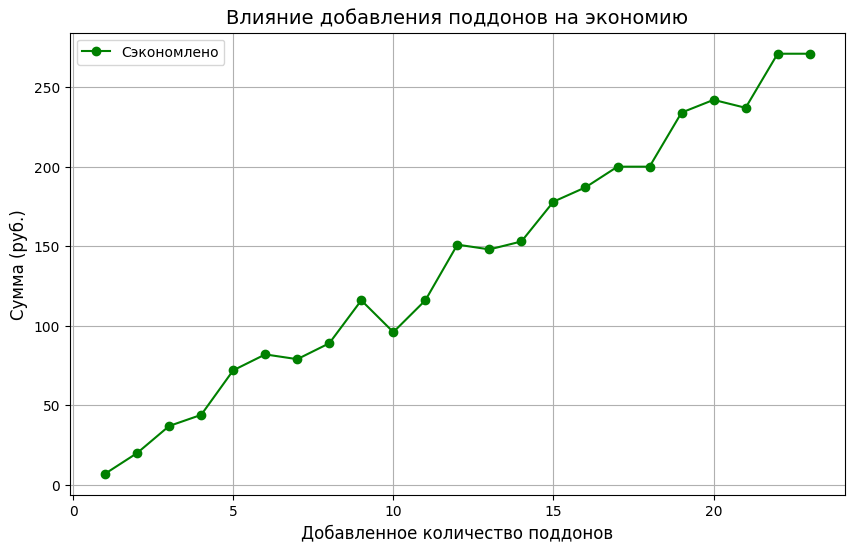

In [20]:
# Импортируем библиотеку для построения графиков
import matplotlib.pyplot as plt

# Проводим симуляцию для текущих параметров производственной линии
work_hours_per_week = 5 * 16  # Рабочая неделя: 5 дней по 16 часов
initial_loss, initial_lost_details = run_simulation(work_hours_per_week, NUM_PALLETS, False)

# Отображаем результаты симуляции для исходного количества поддонов
print(f"Изначальные потери за неделю: {initial_loss} руб.")
print(f"Потерянные детали: {initial_lost_details} \n")

# Списки для хранения данных графика
pallet_counts = []
savings_values = []
modification_costs = []
net_savings_values = []

# Анализируем влияние увеличения количества поддонов на потери
for extra_pallets in range(1, 24):  # Пробуем добавить от 1 до 24 поддонов
    num_pallets = NUM_PALLETS + extra_pallets  # Новое количество поддонов
    if extra_pallets == 1:  # Если добавляем 1 поддон
        modification_cost = 200_000
    else:  # Если добавляем более одного поддона
        modification_cost = 200_000 + 50_000 * (extra_pallets - 1)

    modified_loss, modified_lost_details = run_simulation(work_hours_per_week, num_pallets, True)

    # Рассчитываем эффективность улучшений
    savings = initial_loss - modified_loss
    net_savings = savings - modification_cost

    # Сохраняем данные для графика
    pallet_counts.append(extra_pallets)
    savings_values.append(savings)
    modification_costs.append(modification_cost)
    net_savings_values.append(net_savings)

    print(f"Добавлено поддонов: {extra_pallets}, Сэкономлено: {savings} руб., Стоимость модификации: {modification_cost} руб.")
    print(f"Потерянные детали: {modified_lost_details} \n")

# Строим график
plt.figure(figsize=(10, 6))
plt.plot(pallet_counts, savings_values, label="Сэкономлено", marker='o', color='green')
plt.xlabel("Добавленное количество поддонов", fontsize=12)
plt.ylabel("Сумма (руб.)", fontsize=12)
plt.title("Влияние добавления поддонов на экономию", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

Добавлено поддонов: 1, Сэкономлено: 15 руб., Стоимость модификации: 200000 руб.
Потерянные детали: {'A': 949, 'B': 1582, 'C': 1188}

Добавлено поддонов: 2, Сэкономлено: 25 руб., Стоимость модификации: 250000 руб.
Потерянные детали: {'A': 949, 'B': 1581, 'C': 1188}

Добавлено поддонов: 3, Сэкономлено: 52 руб., Стоимость модификации: 300000 руб.
Потерянные детали: {'A': 948, 'B': 1581, 'C': 1187}

Добавлено поддонов: 4, Сэкономлено: 57 руб., Стоимость модификации: 350000 руб.
Потерянные детали: {'A': 949, 'B': 1579, 'C': 1187}

Добавлено поддонов: 5, Сэкономлено: 97 руб., Стоимость модификации: 400000 руб.
Потерянные детали: {'A': 947, 'B': 1578, 'C': 1187}

Добавлено поддонов: 6, Сэкономлено: 72 руб., Стоимость модификации: 450000 руб.
Потерянные детали: {'A': 948, 'B': 1579, 'C': 1187}

Добавлено поддонов: 7, Сэкономлено: 84 руб., Стоимость модификации: 500000 руб.
Потерянные детали: {'A': 948, 'B': 1579, 'C': 1186}

Добавлено поддонов: 8, Сэкономлено: 104 руб., Стоимость модификации: 

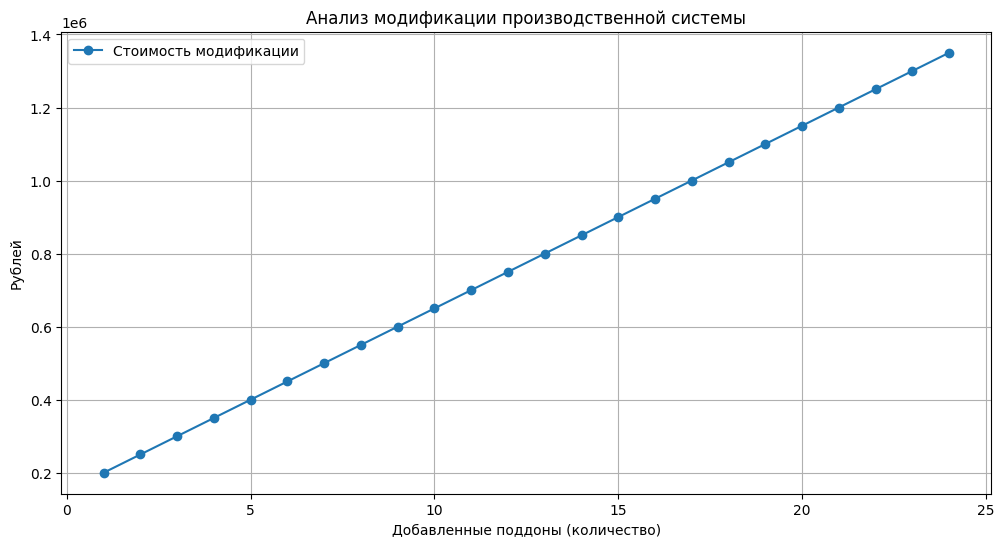

In [19]:
# Импортируем библиотеку для визуализации
import matplotlib.pyplot as plt

# Проводим начальную симуляцию для текущих условий
work_hours_per_week = 5 * 16  # Рабочая неделя: 5 дней по 16 часов
initial_loss, initial_lost_details = run_simulation(work_hours_per_week, NUM_PALLETS, False)

# Списки для хранения результатов
modification_costs = []
savings = []
net_savings_list = []

# Проводим анализ добавления поддонов
for extra_pallets in range(1, 25):  # Рассматриваем добавление поддонов от 1 до 24
    num_pallets = NUM_PALLETS + extra_pallets
    if extra_pallets == 1:
        modification_cost = 200_000
    else:
        modification_cost = 200_000 + 50_000 * (extra_pallets - 1)

    modified_loss, modified_lost_details = run_simulation(work_hours_per_week, num_pallets, True)

    # Рассчитываем экономическую эффективность
    saving = initial_loss - modified_loss
    net_saving = saving - modification_cost

    # Сохраняем результаты
    modification_costs.append(modification_cost)
    savings.append(saving)
    net_savings_list.append(net_saving)

    # Печатаем результаты анализа
    print(f"Добавлено поддонов: {extra_pallets}, Сэкономлено: {saving} руб., Стоимость модификации: {modification_cost} руб.")
    print(f"Потерянные детали: {modified_lost_details}\n")

# Визуализация результатов анализа
plt.figure(figsize=(12, 6))
plt.plot(range(1, 25), modification_costs, label='Стоимость модификации', marker='o')

# Настройка графика
plt.title("Анализ модификации производственной системы")
plt.xlabel("Добавленные поддоны (количество)")
plt.ylabel("Рублей")
plt.legend()
plt.grid(True)
plt.show()